# (day4) Section 5: Transformer ( 実装演習 )

本書は、「深層学習後編（day4）レポート」の、「Section 5: Transformer」 ( 実装演習 ) についてのものです。


### lecture_chap1_exercise_public.ipynb ( Seq2seq )


`module 'pip' has no attribute 'pep425tags'` のエラーと、その回避を試みて実行した。


他の皆さんも同じ事象が発生しているようであったが、

- 参考: [Stage4 · toshinobu-0122/Study-AI-Rabbit-Challenge Wiki](https://github.com/toshinobu-0122/Study-AI-Rabbit-Challenge/wiki/Stage4#lecture_chap1_exercise_publicipynb-1)


- 参考: [深層学習 Day 4 - Seq2Seq のまとめ - Qiita](https://qiita.com/amateur2020/items/6a07642ce9eaa02a805b)<br/>
  `wheel` をダウングレード。<br/>


上記の方の、 `wheel` ダウングレードを試したが、

```
  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.0 from http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl
1.10.0+cu111
True
```


リンク先のパスの構造が変わっていて、また、この URL のモジュール (torch-0.4.0-cp37-cp37m-linux_x86_64.wh) も存在しなかった。

以下の様に、存在する "torch-0.4.1-cp37-cp37m-linux_x86_64.whl" でも解消できなかった。

```python
!pip install "wheel==0.34.2"

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print(f"accelerator={accelerator}, platform={platform}")

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

```

```
accelerator=cu80, platform=cp37-cp37m
  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu80/torch/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu80/torch/torch-0.4.1-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch/torch-0.4.1-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu80/torch/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
1.10.0+cu111
True
```

ブラウザから、

http://download.pytorch.org/whl/cu80/torch/torch-0.4.1-cp37-cp37m-linux_x86_64.whl

にアクセスしても、 `AccessDenied` となったため、断念。


最終コードセル[68]での、以下のエラーを回避できなかった。

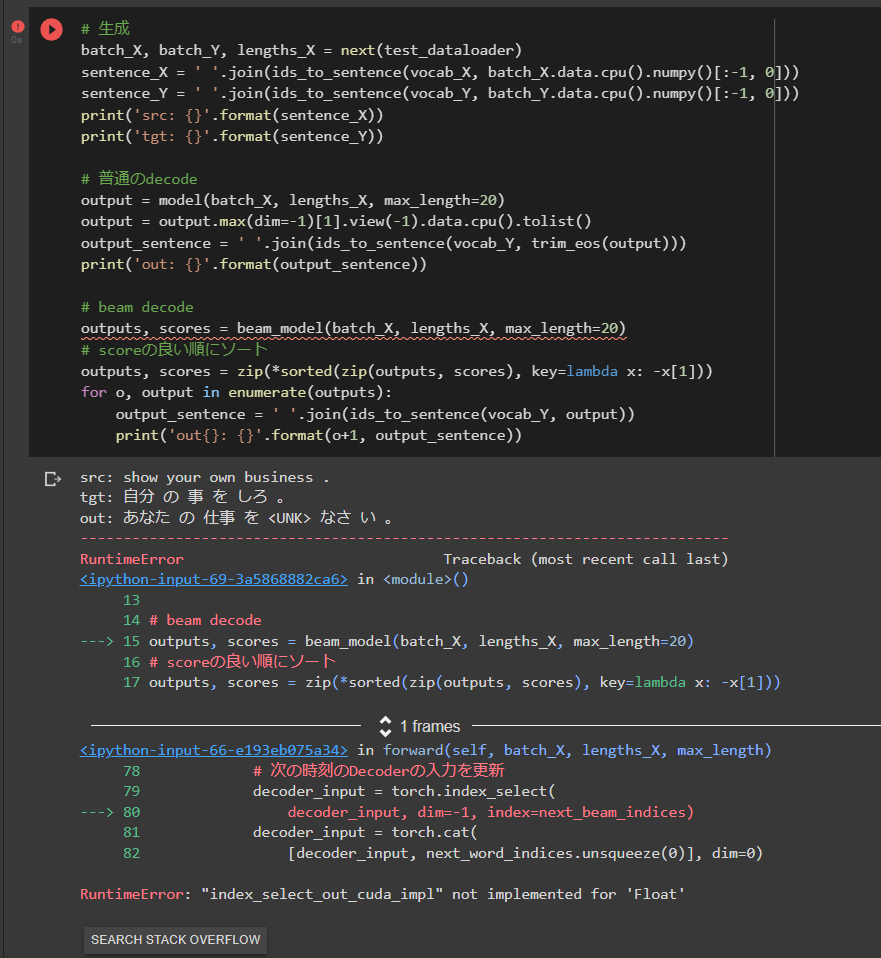

"Beam Search" (`BeamEncoderDecoder`) の確認はできなかった。

結果、キャプチャの通り、最終の1つ前のセルまでを実行した。

#### キャプチャ

自身の環境において、最終コードセル[68]の1つ前までの実行を確認した。


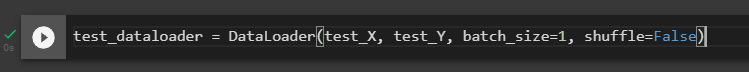

#### 内容

実装演習の際、確認した内容を記録する。


- "1.2単語辞書の作成"

この部分は、 "(day3) Section 5: Seq2Seq / 5-1 Encoder RNN" での、 Taking に相当する。


```python
MIN_COUNT = 2  # 語彙に含める単語の最低出現回数 再提出現回数に満たない単語はUNKに置き換えられる
```

2 回以上出現しないと、ボキャブラリには含めないということ。


作成されたボキャブラリの確認。

```python
vocab_X.id2word
```

`vocab_X` の、 `class Vocab` のコードは、以下。 (セル[2]で `wget` していたもの)

- https://www.dropbox.com/s/9narw5x4uizmehh/utils.py



- "2.1 IDへの変換"

ここも Taking の工程。


- "3.モデルの構築"

`class Encoder` で、 Embedding を行う。

Encoder の学習方法結果である、内部状態ベクトルは、以下で出力。

```python
    def forward(self, seqs, input_lengths, hidden=None):
        """
...
        :return hidden: tensor, Encoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
...
        output, hidden = self.gru(packed, hidden)
        output, _ = pad_packed_sequence(output)
        return output, hidden
```

`pad_packed_sequence(output)` は、
`<PAD>` を使用していることを、 PyTorch に指示するための手続き。


`class EncoderDecoder` が、 Encoder-Decoder モデル。

```python
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
```


以下の部分が、講義資料 page. 17 の問題の箇所。

```python
            # 次の時刻のdecoderの入力を決定
            if use_teacher_forcing and batch_Y is not None:  # teacher forceの場合、ターゲット系列を用いる
                decoder_input = batch_Y[t].unsqueeze(0)
            else:  # teacher forceでない場合、自身の出力を用いる
                decoder_input = decoder_output.max(-1)[1]
```

時系列の最初の方で間違うと、その後の時系列で誤差が大きくなっていく。
その対策として、演習のノートからの引用より、

> **Teacher Forcing**というテクニックがあります。
これは、訓練時にはDecoder側の入力に、ターゲット系列（参照訳）をそのまま使うというものです。
これにより学習が安定し、収束が早くなるというメリットがありますが、逆に評価時は前の時刻にDecoderが生成したものが使われるため、学習時と分布が異なってしまうというデメリットもあります。


これを、後続の `def compute_loss` の中で、

```python
    # 一定確率でTeacher Forcingを行う
    use_teacher_forcing = is_train and (random.random() < teacher_forcing_rate)
```

するのが、 "Scheduled Sampling" という手法。


- "4.1 損失関数の定義"

パディングは損失計算に含めないこと。


- "4.2学習"

```python
# モデルとOptimizerを定義
model = EncoderDecoder(**model_args).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
```

`to(device)` しないと、 CPU が使われてしまう。


重みの更新は、損失関数の中の、以下の部分。

```python
def compute_loss(batch_X, batch_Y, lengths_X, model, optimizer=None, is_train=True):
    # 損失を計算する関数
...
    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```


`calc_bleu` は、翻訳の精度を相対的に測るもの。

`for batch in train_dataloader:` としているのは、データ量が大きくてメモリが足りないことが普通なので、バッチ単位でデータをメモリに読み込んで準備(前処理)をするため。


### lecture_chap2_exercise_public.ipynb ( Transformer )

#### キャプチャ

自身の環境において、最終コードセル[39]までの実行を確認した。


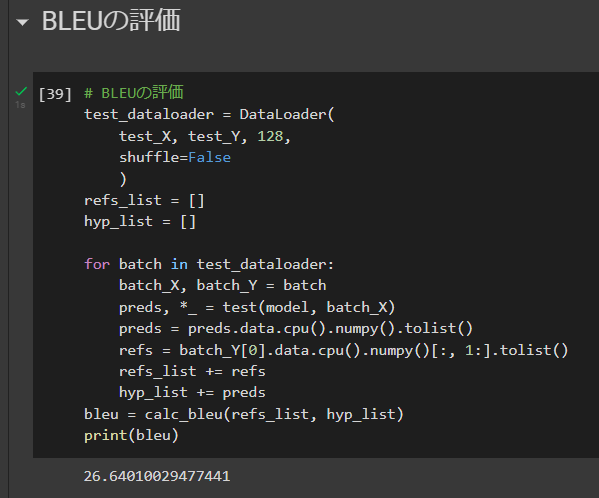

#### 内容

実装演習の際、確認した内容を記録する。


データセットは、 "lecture_chap1_exercise_public.ipynb ( Seq2seq )" と同じ。


- "2.各モジュールの定義"

準備するものは、大きく 4 つ。

- Positional Encoding
- Scaled Dot-Product Attention
- Multi-head Attention
- Position-Wise Feed Forward Network



- "② Multihead Attention"

他の翻訳モデルで使うのは、講義資料 page. 11 の、 "Source Target Attention" 。
Transformer では、 "Self-Attention" も使っている。

使用箇所は、

```python
class EncoderLayer(nn.Module):
    """Encoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
...
        # Encoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
```

```python
class DecoderLayer(nn.Module):
    """Decoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        # Decoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Encoder-Decoder間のSource-Target Attention
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
```


- "Scaled Dot-Product Attention"

スケーリング因子は、内積計算の爆発を防ぐ仕組み。箇所は、

```python
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, d_model, attn_dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param attn_dropout: float, ドロップアウト率
        """
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)  # スケーリング因子
...
    def forward(self, q, k, v, attn_mask):
...
        # QとKの内積でAttentionの重みを求め、スケーリングする
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temper  # (n_head*batch_size, len_q, len_k)
```


講義資料 page. 17 の、未来の情報を見ないようにマスクしている箇所は、以下。<br/>
( 先程のスケーリング因子適用部分の次の行 )

```python
        # Attentionをかけたくない部分がある場合は、その部分を負の無限大に飛ばしてSoftmaxの値が0になるようにする
        attn.data.masked_fill_(attn_mask, -float('inf'))
```

`attn_mask` は、 `forward()` の引数。

Q, V, softmax, V を適用して、計算しているのが、以下。
講義資料 page. 15 に対応する部分。

```python
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)
```


- NOTE: `attn_mask` は、 "④ Masking" で作成されたマスク。<br/>
  目的は、 PAD を無視するため。


講義資料 page. 16 の V, K, Q に Linear ( 線形変換 ) する箇所は、
`class MultiHeadAttention` の、 `def __init__` 部分。

<!-- ```python
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
...
        # 各ヘッドごとに異なる重みで線形変換を行うための重み
        # nn.Parameterを使うことで、Moduleのパラメータとして登録できる. TFでは更新が必要な変数はtf.Variableでラップするのでわかりやすい
        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))
``` -->

`self.n_head = n_head` が、ヘッドの数。 ( 今回は 8 )
この分、 `class MultiHeadAttention` / `def forward` の中で、 `repeat` して作成してる。

Source-Target Attention も Self-attention も `class MultiHeadAttention` で共通。
引き渡される隠れ状態が異なるだけ。


- "③ Position-Wise Feed Forward Network"

`class PositionwiseFeedForward` で、講義資料 page. 14 のネットワークを作成している。


- NOTE: [「テンソル」「ベクトル」「行列」とは？ディープラーニングの情報整理のカラクリ 連載：図でわかる3分間AIキソ講座｜ビジネス+IT](https://www.sbbit.jp/article/cont1/63580)<br/>
  テンソルについて、例えば、 numpy の以下の様なものと理解した。

In [ ]:
import numpy as np

a = np.array([
              [[1, 2, 3], [4, 5, 6,], [7, 8, 9]],
              [[1, 2, 3], [4, 5, 6,], [7, 8, 9]],
              [[1, 2, 3], [4, 5, 6,], [7, 8, 9]]
])

a.shape

(3, 3, 3)

- "④ Masking"

講義資料 page. 17 の、未来の情報を見ないようにするためのマスクを作成しているのは、
`def get_attn_subsequent_mask`

- "3. モデルの定義" / "Encoder"

`class EncoderLayer` を構成して、それを `n_layers=6` 層構成しているのが、
`class Encoder` 。

Position Encoding は、 `class Encoder` の `def forward` にて。 ( 勿論、 Decoder でも使用箇所あり )


- "Decoder"

Attention の使い方の違いは、 `class DecoderLayer` の `def forward`

```python
        # Self-Attentionのquery, key, valueにはすべてDecoderの入力（dec_input）が入る
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, attn_mask=slf_attn_mask)
        # Source-Target-AttentionのqueryにはDecoderの出力(dec_output), key, valueにはEncoderの出力（enc_output）が入る
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, attn_mask=dec_enc_attn_mask)
```

講義資料 page. 12 の、右図、さらに右側の Decoder 内、 Multi-Head Attention への 3 つの矢印に対応する入力。


`class Decoder` で、 Encoder と違う部分は、マスク。
未来の情報を見ないようにするためのマスク。

`class Transformer` で、 Encoder と Decoder を結合。

`def forward` で、隠れ状態 `enc_output` を
Encoder から Decoder に引き渡している。

`seq_logit = self.tgt_word_proj(dec_output)` の部分が、
先程の 講義資料 page. 12 の、 Decoder 部分の出力。 "Linear" ( 線形変換 ) している。


- "4. 学習"



前回、"lecture_chap1_exercise_public.ipynb ( Seq2seq )" の、 `# BLEUの計算` では、以下だった。

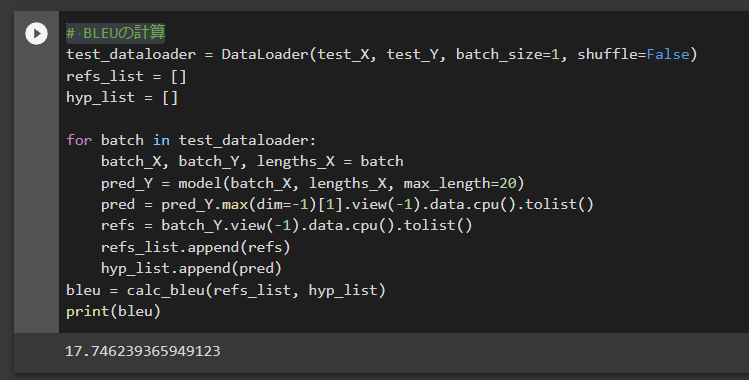

それに対し、今回の、 "lecture_chap2_exercise_public.ipynb ( Transformer )" では、より高い評価を得た。</br>
( キャプチャ再掲 )

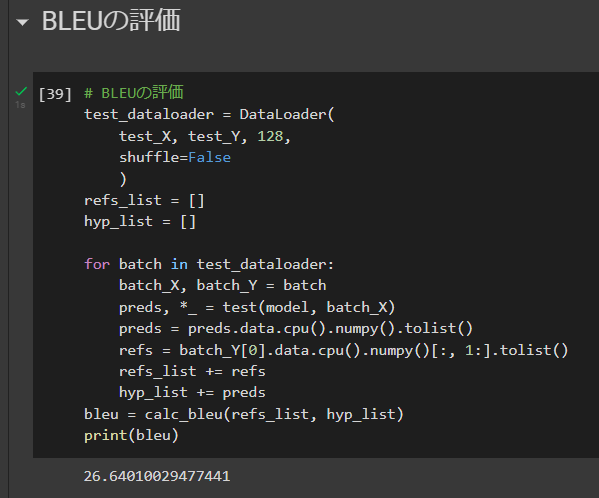